## SAM - license plate detection

Import Everything

In [1]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import os


Helper Functions

In [19]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

def get_coord(img, ann_name):
    f = open(f"data/labels/{ann_name}")
    w = img.shape[1]
    h = img.shape[0]
    line = f.readline()
    line = line.split(" ")
    labels = line[0]
    center_x, center_y, w, h = w*float(line[1]), h*float(line[2]), w*float(line[3]), h*float(line[4])

    x1 = center_x - (w/2)
    y1 = center_y - (h/2)
    x2 = center_x + (w/2)
    y2 = center_y + (h/2)
    f.close()

    return labels, np.array([x1, y1, x2, y2])

def get_coords(img, ann_name):
    f = open(f"data/labels/{ann_name}")
    w = img.shape[1]
    h = img.shape[0]
    labels = -1
    boxes = []
    # center_x, center_y, w, h = 0, 0, 0, 0
    for line in f:
        # print("line:", line)
        line = line.split(" ")
        # print("line split:", line)
        labels = line[0]
        center_x = w*float(line[1])
        center_y = h*float(line[2])
        x = w*float(line[3])
        y = h*float(line[4])
        # print("centers and w/h:", center_x, center_y, w, h)

        x1 = center_x - (x/2)
        y1 = center_y - (y/2)
        x2 = center_x + (x/2)
        y2 = center_y + (y/2)
        # print("coords:" , x1, y1, x2, y2)
        boxes.append([x1, y1, x2, y2])
    f.close()

    return labels, torch.tensor(boxes, device=predictor.device)

def get_txt(img_name):
    name = img_name.split(".")[0]
    return f"{name}.txt"


##### Configure Device

In [3]:
DEVICE = "cuda"
checkpoint = "sam_vit_h_4b8939.pth"
model = "vit_h"

sam = sam_model_registry[model](checkpoint)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)


### One image, One Mask

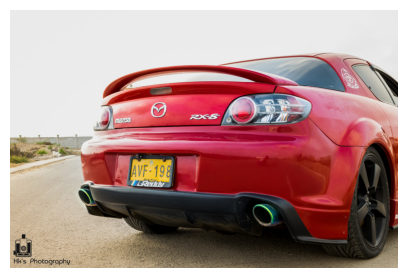

In [4]:
# load in image
img = cv2.imread('data/images/0cacb08195a3e2d7.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.show()

Get Mask

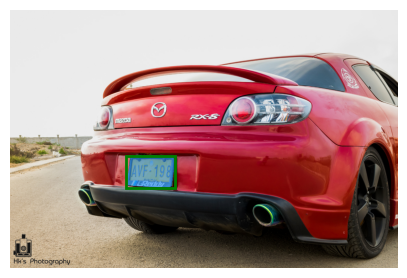

In [5]:
predictor.set_image(img)        # set the image

ann_name = get_txt('0cacb08195a3e2d7.jpg')      # get annotate file name
_, box = get_coord(img, ann_name)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(5,5))
plt.imshow(img)
show_mask(masks[0], plt.gca())
show_box(box, plt.gca())
plt.axis('off')
plt.show()

#### Multiple Masks

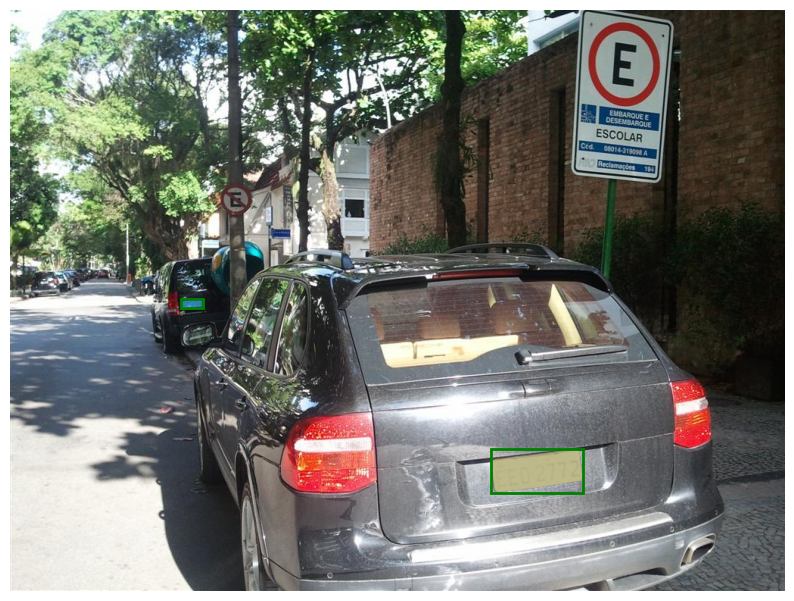

In [20]:
img = cv2.imread('data/images/0c756c9366a8cb10.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.subplot(1, 2, 1)
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# masks
predictor.set_image(img)        # set the image

ann_name = get_txt('0c756c9366a8cb10.jpg')      # get annotate file name
_, boxes = get_coords(img, ann_name)
# print(boxes)

transformed_boxes = predictor.transform.apply_boxes_torch(boxes, img.shape[:2])
# print(transformed_boxes)
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
# plt.subplot(1, 2, 2)
plt.figure(figsize=(10, 10))
plt.imshow(img)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in boxes:
    show_box(box.cpu().numpy(), plt.gca())
    # print(box)
plt.axis('off')
plt.show()
# plt.imshow(img)

# for m in masks:
#     show_mask(m.cpu().numpy(), plt.gca(), random_color=True)
# for b in boxes:
#     show_box(b.cpu().numpy(), plt.gca())
# plt.axis('off')
# plt.show()

#### Multiple Images & Multiple Masks

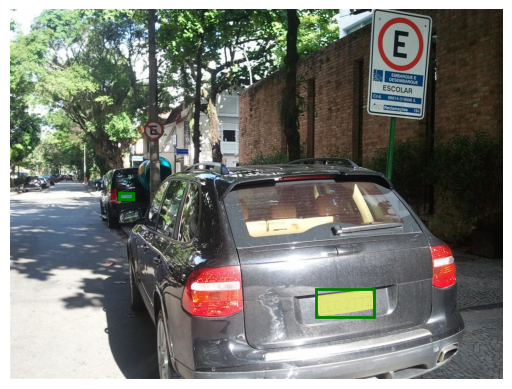

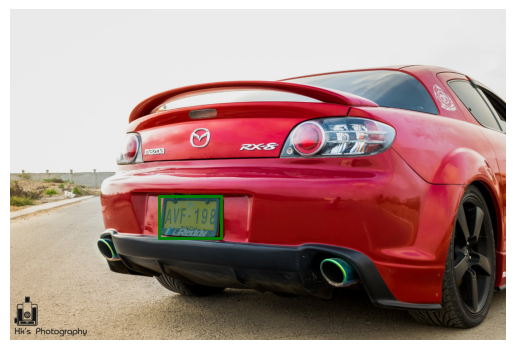

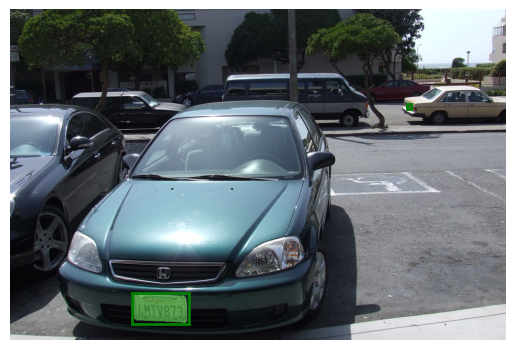

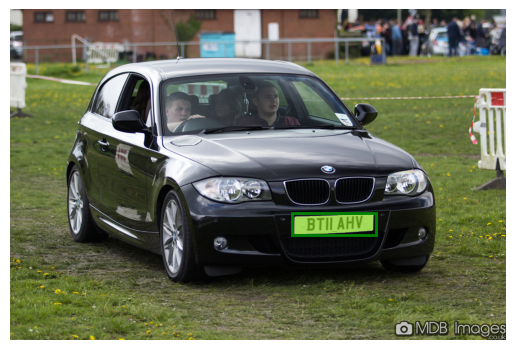

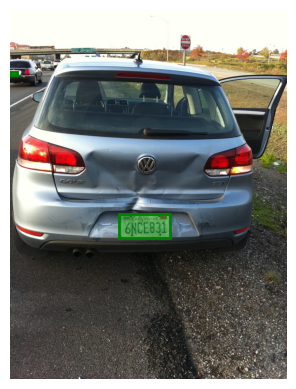

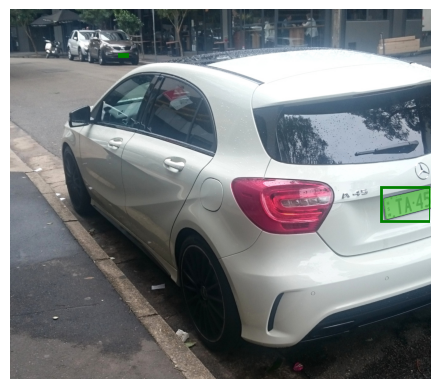

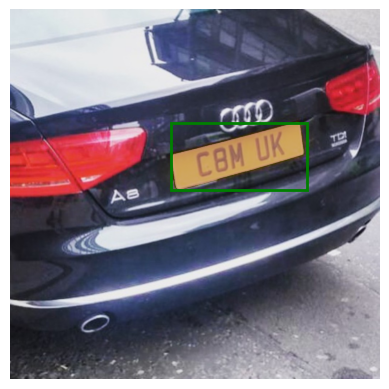

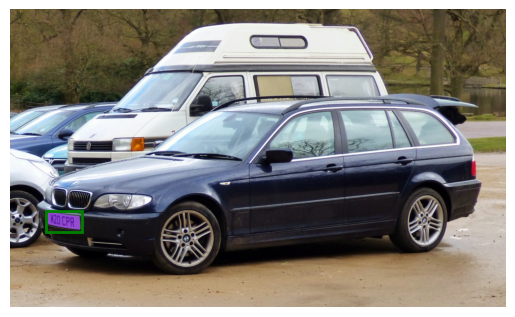

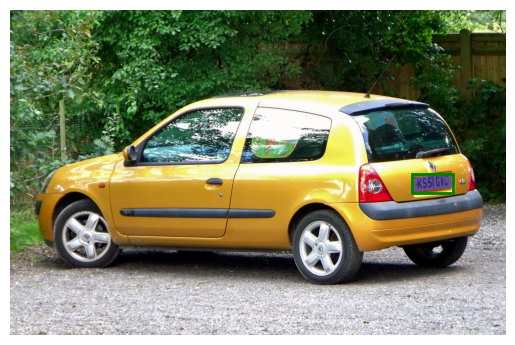

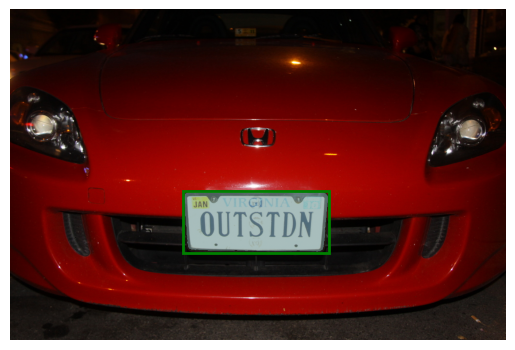

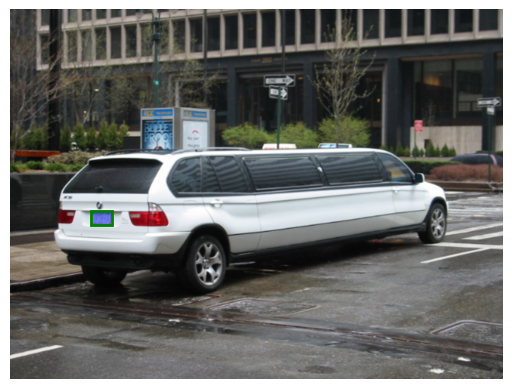

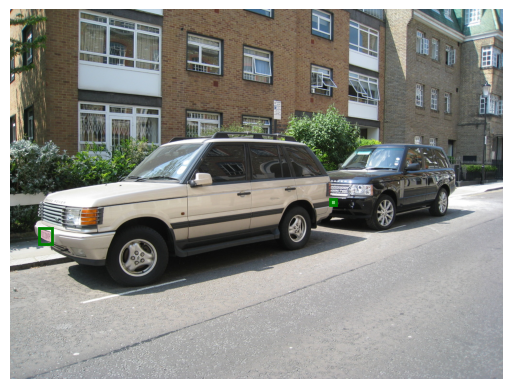

In [21]:
directory = "data/images"
for image in os.listdir(directory):
    # f, axarr = plt.subplots(1, 2)
    # axarr[0, 0] = imshow(img)
    img = cv2.imread(f"{directory}/{image}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predictor.set_image(img)

    ann_name = get_txt(image)
    _, boxes = get_coords(img, ann_name)

    transformed_boxes = predictor.transform.apply_boxes_torch(boxes, img.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )


    # plot side by side
    # plt.subplot(1, 2, 1)
    # plt.imshow(img)
    # plt.axis('off')
    # plt.show()

    # plt.subplot(1, 2, 2)
    plt.imshow(img)
    
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
    for box in boxes:
        show_box(box.cpu().numpy(), plt.gca())
    plt.axis('off')
    plt.show()



In [23]:
masks*1

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0')